In [16]:
# Libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import stumpy
from matplotlib.patches import Rectangle
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import Image
from scipy.stats import boxcox
from pmdarima import auto_arima
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from sklearn.metrics import silhouette_score 
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance,TimeSeriesResampler
from tslearn.metrics import cdist_dtw
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

<div style="background-color:rgb(255, 132, 91); padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">

# 5-A: Data Preparation and Exploration

</div>

<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">

1. **Clean the dataset**:
   - Clean the dataset.
   - Address missing values. 
   - Change the data types to make the data useable 

In [2]:
# Importing and displaying the initial rows in the dataset
dow_jones = pd.read_csv('dow_jones_index.data')
display(dow_jones)

# We need to remove the dollar signs and change the datatype to float in some of the numerical columns 
columns_to_change = ["open", "high", "low", "close", "next_weeks_open", "next_weeks_close"]
for column in columns_to_change:
    dow_jones[column] = dow_jones[column].replace({"\\$": ""}, regex=True).astype(float)

# Printing unique values in the stock column to confirm that it contains 30 unique stocks as dow jones should
print(f'There are {len(dow_jones["stock"].unique())} unique stocks as there should be')

# There are some NaN values at a few rows. Since we can not remova any rows which would create gaps in the timeseries, we are going to impute them with backfill.
# Columns backfilled are "percent_change_volume_over_last_wk" and "previous_weeks_volume" for the first week of every stock.
na_indices = dow_jones[dow_jones.isna().any(axis=1)].index
na_rows = dow_jones.iloc[na_indices]
dow_jones.fillna(method="bfill", inplace=True)

# Since we are going to be working with the 'close' feature in the supervised part, we want to craete a separate and scaled dataframe containing just the 'close' column with 'date' as its index.
# To represent the market average, we are also going to aggregate the 'close' column. Lastly, we also want to change the 'date' column datatype into datetime objects.
scaler = MinMaxScaler()
close_df = dow_jones[['date', 'close']]
scaled_data = scaler.fit_transform(np.array(close_df['close']).reshape(-1, 1))
close_df = close_df.assign(close=scaled_data)
close_df = close_df.groupby(by=['date']).mean()
close_df = close_df.reset_index()
close_df = close_df.assign(date = [datetime.strptime(date_str, '%m/%d/%Y').date() for date_str in close_df['date']])
close_df = close_df.set_index(close_df['date'])
close_df = close_df.drop(columns=['date'])
close_df = close_df.sort_index()

# displaying the cleaned dataframe again
display(dow_jones)
display(close_df)

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2,XOM,5/27/2011,$80.22,$82.63,$80.07,$82.63,68230855,3.00424,-21.355713,86758820.0,$83.28,$81.18,-2.521610,75,0.568801
746,2,XOM,6/3/2011,$83.28,$83.75,$80.18,$81.18,78616295,-2.52161,15.221032,68230855.0,$80.93,$79.78,-1.420980,68,0.578960
747,2,XOM,6/10/2011,$80.93,$81.87,$79.72,$79.78,92380844,-1.42098,17.508519,78616295.0,$80.00,$79.02,-1.225000,61,0.589120
748,2,XOM,6/17/2011,$80.00,$80.82,$78.33,$79.02,100521400,-1.22500,8.811952,92380844.0,$78.65,$76.78,-2.377620,54,0.594786


There are 30 unique stocks as there should be


C:\Users\victo\AppData\Local\Temp\ipykernel_21684\329257805.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dow_jones.fillna(method="bfill", inplace=True)


,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,15.82,16.72,15.78,16.42,239655616,3.79267,1.380223,239655616.0,16.71,15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223,239655616.0,16.19,15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.024959,242963398.0,15.87,16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500,138428495.0,16.18,17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,16.18,17.39,16.18,17.14,154387761,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97,0.175029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2,XOM,5/27/2011,80.22,82.63,80.07,82.63,68230855,3.00424,-21.355713,86758820.0,83.28,81.18,-2.521610,75,0.568801
746,2,XOM,6/3/2011,83.28,83.75,80.18,81.18,78616295,-2.52161,15.221032,68230855.0,80.93,79.78,-1.420980,68,0.578960
747,2,XOM,6/10/2011,80.93,81.87,79.72,79.78,92380844,-1.42098,17.508519,78616295.0,80.00,79.02,-1.225000,61,0.589120
748,2,XOM,6/17/2011,80.00,80.82,78.33,79.02,100521400,-1.22500,8.811952,92380844.0,78.65,76.78,-2.377620,54,0.594786


,close
date,
2011-01-07,0.255529
2011-01-14,0.258624
2011-01-21,0.260946
2011-01-28,0.259621
2011-02-04,0.267004
2011-02-11,0.271992
2011-02-18,0.275230
2011-02-25,0.268070
2011-03-04,0.269128


<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">

2. **Summarize the dataset using  descriptive statistics.** ✅

,close
count,25.000000
mean,0.269957
std,0.008181
min,0.255529
25%,0.263168
50%,0.269128
75%,0.275230
max,0.286742


,quarter,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
count,750.000000,750.000000,750.000000,750.000000,750.000000,7.500000e+02,750.000000,750.000000,7.500000e+02,750.000000,750.000000,750.000000,750.000000,750.000000
mean,1.520000,53.651840,54.669987,52.640160,53.729267,1.175478e+08,0.050262,4.315595,1.192601e+08,53.702440,53.889080,0.238468,52.525333,0.691826
std,0.499933,32.638852,33.215994,32.119277,32.788787,1.584381e+08,2.517809,40.468295,1.650218e+08,32.778111,33.016677,2.679538,46.335098,0.305482
min,1.000000,10.590000,10.940000,10.400000,10.520000,9.718851e+06,-15.422900,-61.433175,9.718851e+06,10.520000,10.520000,-15.422900,0.000000,0.065574
25%,1.000000,29.830000,30.627500,28.720000,30.365000,3.086624e+07,-1.288053,-21.684982,3.086624e+07,30.315000,30.462500,-1.222068,24.000000,0.534549
50%,2.000000,45.970000,46.885000,44.800000,45.930000,5.306088e+07,0.000000,-0.984000,5.338195e+07,46.015000,46.125000,0.101193,47.000000,0.681067
75%,2.000000,72.715000,74.287500,71.037500,72.667500,1.327218e+08,1.650888,20.695908,1.373260e+08,72.715000,72.915000,1.845562,69.000000,0.854291
max,2.000000,172.110000,173.540000,167.820000,170.580000,1.453439e+09,9.882230,327.408924,1.453439e+09,172.110000,174.540000,9.882230,336.000000,1.564210


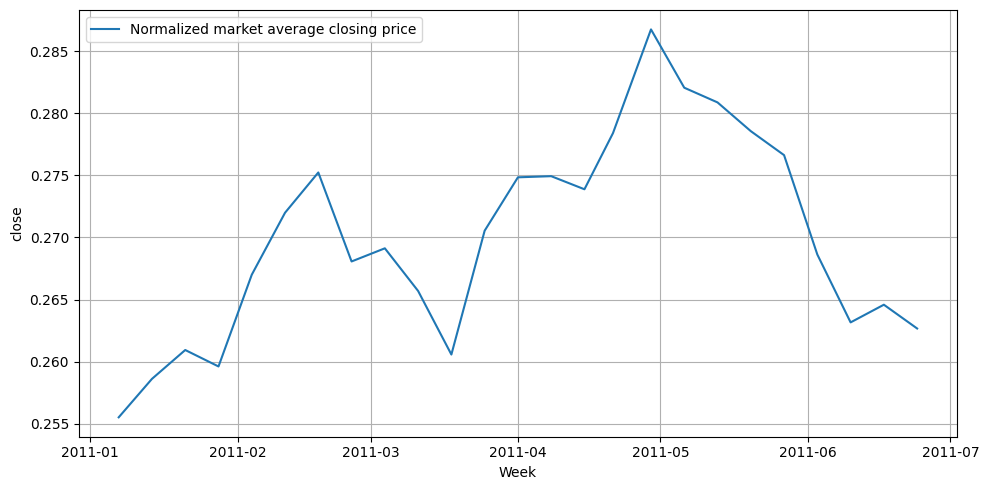

In [3]:
# Summarizing the two dataframes
display(close_df.describe(), dow_jones.describe())

# Plotting the timeseries we are going to be forecasting and predicting later
fig, ax = plt.subplots(1,1, figsize = (10, 5))
sns.lineplot(data=close_df, x='date', y='close', ax=ax, label='Normalized market average closing price')
ax.legend()
ax.set_xlabel('Week')
ax.grid()
plt.tight_layout()
plt.show()

<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">

3. **Apply additional techniques**:
   - Perform dimension reduction. 
   - Visualize insights and trends. 
   - Identify anomalies using unsupervised methods. 

Explained variance per component (90% PCA): [0.47707839 0.11971871 0.09236869 0.07279125 0.07010224 0.06579718
 0.05460627]
Cumulative explained variance (90% PCA): [0.47707839 0.5967971  0.68916579 0.76195704 0.83205928 0.89785646
 0.95246273]


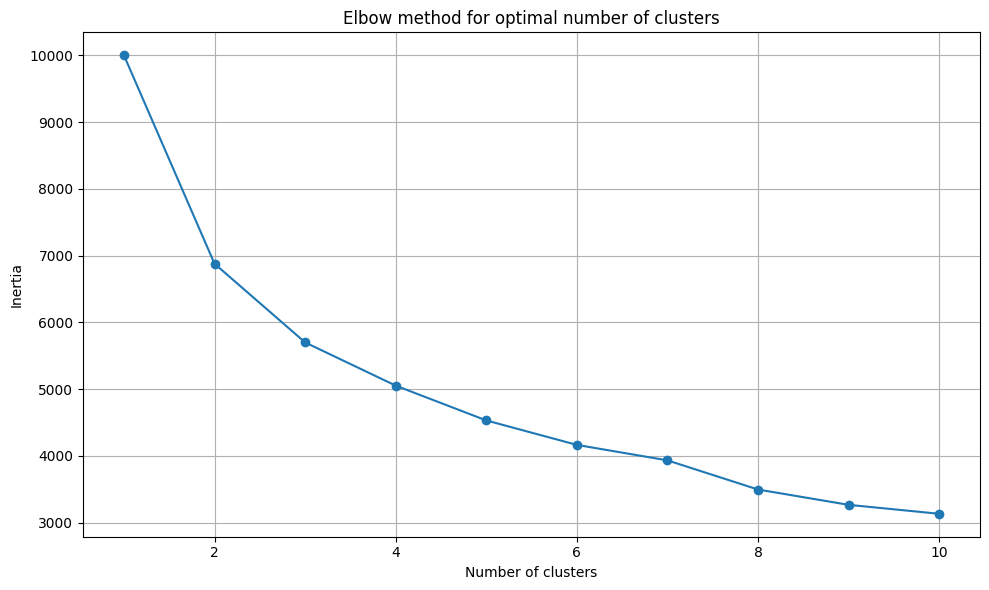

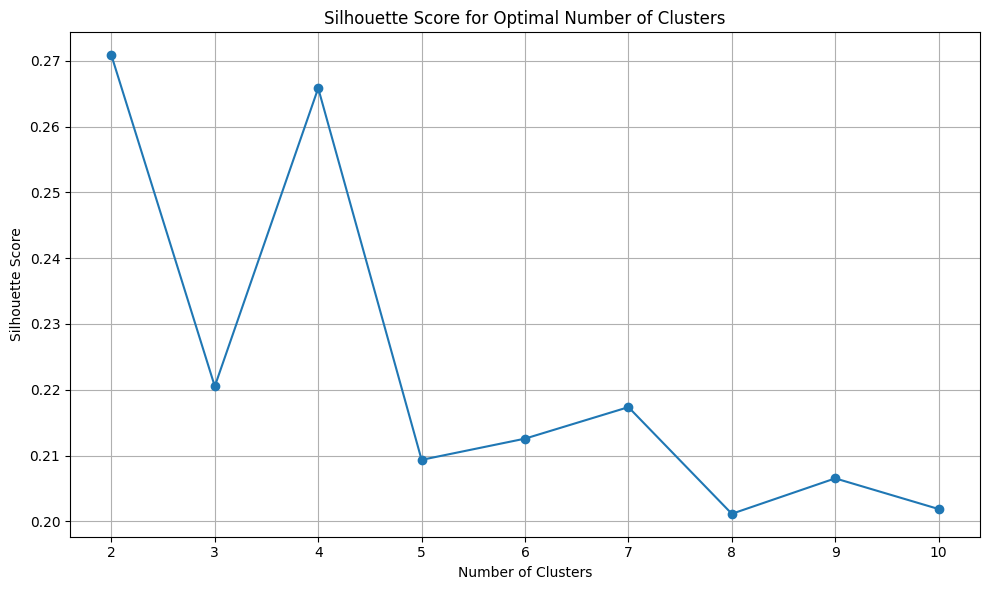

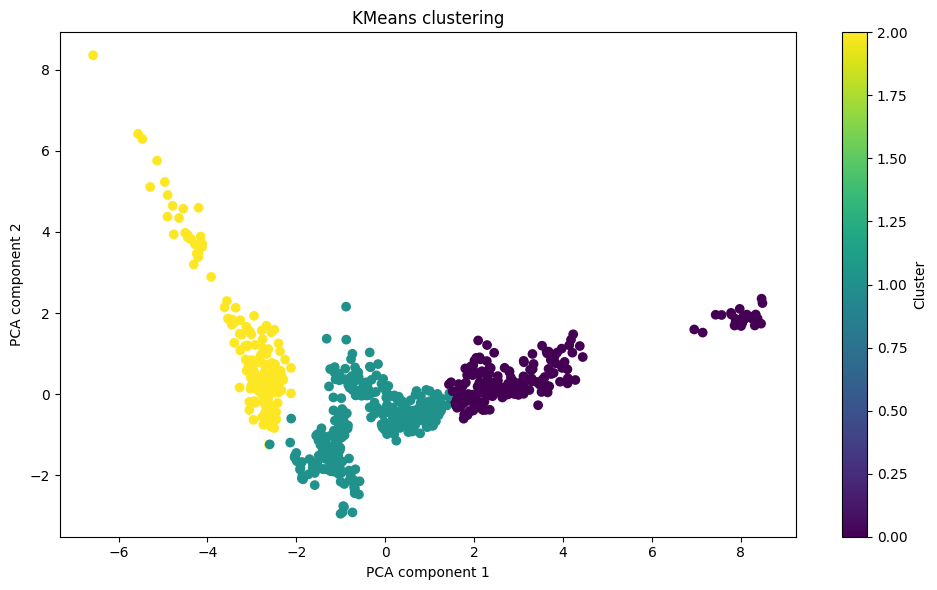

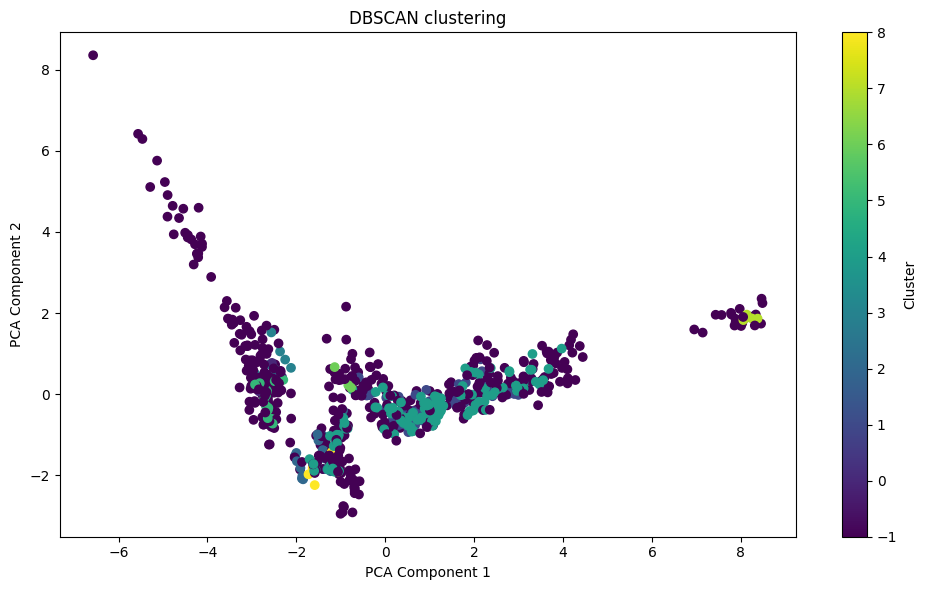

'Cluster 0 (KMeans):'

"Cluster 0: Unique stocks are: ['BA' 'CAT' 'CVX' 'IBM' 'MCD' 'MMM' 'UTX' 'XOM']"

'Cluster 1 (KMeans):'

"Cluster 1: Unique stocks are: ['AXP' 'BA' 'DD' 'DIS' 'HD' 'HPQ' 'JNJ' 'JPM' 'KRFT' 'KO' 'MRK' 'PFE' 'PG'\n 'T' 'TRV' 'VZ' 'WMT']"

'Cluster 2 (KMeans):'

"Cluster 2: Unique stocks are: ['AA' 'BAC' 'CSCO' 'GE' 'INTC' 'MSFT' 'PFE']"

'Cluster 0 (DBSCAN):'

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,kmeans_cluster,dbscan_cluster,PCA1,PCA2
5,1,AA,2/11/2011,17.33,17.48,16.97,17.37,114691279,0.230814,-25.712195,154387761.0,17.39,17.28,-0.632547,90,0.172712,2,0,-2.572640,0.242666
6,1,AA,2/18/2011,17.39,17.68,17.28,17.28,80023895,-0.632547,-30.226696,114691279.0,16.98,16.68,-1.766780,83,0.173611,2,0,-2.492172,0.115574
8,1,AA,3/4/2011,16.81,16.94,16.13,16.58,109493077,-1.368230,-17.663150,132981863.0,16.58,16.03,-3.317250,69,0.180941,2,0,-2.642801,0.419724
114,1,GE,2/18/2011,21.51,21.65,21.24,21.44,158691572,-0.325430,-37.090656,252254376.0,20.88,20.82,-0.287356,118,0.652985,2,0,-2.579984,-0.331362
117,1,GE,3/11/2011,20.40,20.79,19.94,20.36,303566341,-0.196078,16.230827,261175412.0,19.96,19.25,-3.557110,97,0.687623,2,0,-2.940933,0.381905


'Cluster 0: 4 unique stocks'

'Cluster 1 (DBSCAN):'

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,kmeans_cluster,dbscan_cluster,PCA1,PCA2
20,1,AXP,3/4/2011,43.73,44.68,42.75,43.72,38985037,-0.022868,-1.687362,39654146.0,43.86,44.28,0.957592,33,0.411711,1,1,-0.415993,-0.033620
21,1,AXP,3/11/2011,43.86,45.54,43.53,44.28,37613429,0.957592,-3.518293,38985037.0,43.86,44.17,0.706794,26,0.406504,1,1,-0.369070,-0.024892
22,1,AXP,3/18/2011,43.86,44.47,42.19,44.17,41757526,0.706794,11.017600,37613429.0,44.75,45.59,1.877090,19,0.407516,1,1,-0.364371,0.012645
23,1,AXP,3/25/2011,44.75,45.61,44.10,45.59,30798332,1.877090,-26.244835,41757526.0,45.54,45.36,-0.395257,12,0.394823,1,1,-0.282227,0.033786
25,1,BA,1/14/2011,69.42,70.50,68.35,70.07,18834664,0.936330,-48.053942,36258120.0,70.86,71.68,1.157210,26,0.599401,0,1,1.471831,-0.084901


'Cluster 1: 14 unique stocks'

'Cluster 2 (DBSCAN):'

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,kmeans_cluster,dbscan_cluster,PCA1,PCA2
128,1,HD,3/4/2011,37.15,37.86,36.33,37.22,49763519,0.188425,-9.217281,54816070.0,37.26,37.14,-0.322061,4,0.671682,1,2,-0.949997,-0.403790
193,1,KRFT,1/14/2011,30.91,31.72,30.89,31.34,24955086,1.391140,-44.509442,44971770.0,31.41,31.35,-0.191022,74,0.925335,1,2,-1.345845,-1.594199
200,1,KRFT,3/4/2011,31.82,31.88,31.28,31.58,55211152,-0.754243,9.409780,50462721.0,31.56,31.70,0.443599,25,0.918303,1,2,-1.387378,-1.040205
201,1,KRFT,3/11/2011,31.56,31.79,31.18,31.70,41766976,0.443599,-24.350472,55211152.0,31.51,30.99,-1.650270,18,0.914827,1,2,-1.383250,-1.066091
202,1,KRFT,3/18/2011,31.51,31.60,30.45,30.99,51736270,-1.650270,23.868843,41766976.0,30.78,31.26,1.559450,11,0.935786,1,2,-1.405332,-1.022803


'Cluster 2: 5 unique stocks'

'Cluster 3 (DBSCAN):'

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,kmeans_cluster,dbscan_cluster,PCA1,PCA2
61,1,CSCO,1/14/2011,20.94,21.23,20.70,21.21,154708263,1.289400,-49.032988,303545878.0,21.22,20.72,-2.356270,74,0.282885,2,3,-2.598962,0.731393
157,1,INTC,1/14/2011,20.71,21.33,20.57,21.08,274111012,1.786580,-29.118929,386719626.0,21.03,20.82,-0.998573,20,0.853890,2,3,-2.928238,0.505085
252,1,MSFT,1/7/2011,28.05,28.85,27.77,28.60,328646154,1.960780,-30.745780,328646154.0,28.20,28.30,0.354610,39,0.559441,2,3,-2.365803,1.053650
253,1,MSFT,1/14/2011,28.20,28.50,28.00,28.30,227601331,0.354610,-30.745780,328646154.0,28.16,28.02,-0.497159,32,0.565371,2,3,-2.251504,0.852601
254,1,MSFT,1/21/2011,28.16,28.74,28.02,28.02,220040646,-0.497159,-3.321898,227601331.0,28.02,27.75,-0.963597,25,0.571021,2,3,-2.119947,0.648885


'Cluster 3: 3 unique stocks'

'Cluster 4 (DBSCAN):'

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,kmeans_cluster,dbscan_cluster,PCA1,PCA2
373,2,AXP,4/1/2011,45.54,46.29,45.11,45.36,28738689,-0.395257,-6.687515,30798332.0,45.61,46.28,1.468980,5,0.396825,1,4,-0.212704,0.055658
374,2,AXP,4/8/2011,45.61,46.49,45.10,46.28,31114741,1.468980,8.267781,28738689.0,46.36,46.25,-0.237274,82,0.388937,1,4,-0.222087,-0.322991
375,2,AXP,4/15/2011,46.36,46.95,45.60,46.25,29090940,-0.237274,-6.504316,31114741.0,45.85,47.11,2.748090,75,0.389189,1,4,-0.182730,-0.332436
379,2,AXP,5/13/2011,50.06,50.46,49.22,49.49,35427164,-1.138630,-19.479553,43997724.0,49.42,51.19,3.581550,47,0.363710,1,4,0.056988,-0.022292
380,2,AXP,5/20/2011,49.42,51.97,49.17,51.19,36565612,3.581550,3.213489,35427164.0,50.74,51.13,0.768624,40,0.351631,1,4,0.156134,-0.048745


'Cluster 4: 20 unique stocks'

'Cluster 5 (DBSCAN):'

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,kmeans_cluster,dbscan_cluster,PCA1,PCA2
364,2,AA,4/29/2011,16.94,17.24,16.66,17.00,90831895,0.354191,6.565939,85235391.0,17.27,17.15,-0.694847,13,0.176471,2,5,-2.392020,0.347767
478,2,GE,4/8/2011,20.73,20.75,20.07,20.19,238618636,-2.604920,14.777190,207897262.0,20.24,20.04,-0.988142,69,0.693413,2,5,-2.713817,0.116639
479,2,GE,4/15/2011,20.24,20.37,19.60,20.04,212315926,-0.988142,-11.022907,238618636.0,19.77,19.95,0.910470,62,0.698603,2,5,-2.682253,-0.037350
483,2,GE,5/13/2011,19.97,20.42,19.76,19.89,195448891,-0.400601,-16.893934,235180053.0,19.85,19.62,-1.158690,34,0.703871,2,5,-2.658938,0.068594
484,2,GE,5/20/2011,19.85,20.05,19.41,19.62,228297982,-1.158690,16.806998,195448891.0,19.32,19.44,0.621118,27,0.713558,2,5,-2.666198,0.095435


'Cluster 5: 5 unique stocks'

'Cluster 6 (DBSCAN):'

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,kmeans_cluster,dbscan_cluster,PCA1,PCA2
504,2,HPQ,4/8/2011,40.65,41.80,40.20,40.70,87672936,0.123001,-2.661307,90069975.0,40.71,40.26,-1.105380,66,0.319410,1,6,-0.786590,0.238344
508,2,HPQ,5/6/2011,40.69,41.52,39.80,40.81,70249698,0.294913,-14.706734,82362537.0,40.79,40.41,-0.931601,38,0.318549,1,6,-0.730410,0.272041
562,2,JPM,5/20/2011,42.97,44.35,42.65,43.13,145114846,0.372353,5.912651,137013704.0,42.40,42.79,0.919811,42,0.579643,1,6,-0.770387,0.160979
563,2,JPM,5/27/2011,42.40,42.92,41.69,42.79,119828886,0.919811,-17.424792,145114846.0,43.24,41.57,-3.862160,35,0.584249,1,6,-0.831910,0.223720
566,2,JPM,6/17/2011,41.29,42.44,39.70,40.80,183560880,-1.186730,-5.752531,194764785.0,40.50,39.49,-2.493830,14,0.612745,1,6,-1.137737,0.667817


'Cluster 6: 2 unique stocks'

'Cluster 7 (DBSCAN):'

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,kmeans_cluster,dbscan_cluster,PCA1,PCA2
517,2,IBM,4/8/2011,164.42,164.75,163.16,164.05,17615408,-0.225033,-7.685426,19081936.0,163.44,166.21,1.694810,28,0.457178,0,7,8.119955,1.886173
523,2,IBM,5/20/2011,169.81,171.41,166.53,170.16,26027660,0.206113,10.729929,23505533.0,168.50,167.50,-0.593472,80,0.440762,0,7,8.375722,1.862911
524,2,IBM,5/27/2011,168.50,168.60,165.90,167.50,19453763,-0.593472,-25.257349,26027660.0,168.44,165.05,-2.012590,73,0.447761,0,7,8.243819,1.867851
525,2,IBM,6/3/2011,168.44,169.89,164.13,165.05,23349972,-2.012590,20.028048,19453763.0,164.76,163.18,-0.958971,66,0.454408,0,7,8.131639,1.960920
526,2,IBM,6/10/2011,164.76,165.96,162.87,163.18,20646079,-0.958971,-11.579855,23349972.0,164.44,164.44,0.000000,59,0.459615,0,7,8.054741,1.826884


'Cluster 7: 1 unique stocks'

'Cluster 8 (DBSCAN):'

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,kmeans_cluster,dbscan_cluster,PCA1,PCA2
571,2,KRFT,4/21/2011,32.72,33.67,32.70,33.38,33399240,2.017110,-53.307717,71530535.0,33.45,33.59,0.418535,68,0.868784,1,8,-1.202410,-1.424748
674,2,T,4/15/2011,30.75,30.84,30.01,30.65,108080405,-0.325203,-27.074364,148206324.0,30.42,30.68,0.854701,82,1.402940,1,8,-1.727021,-1.975987
675,2,T,4/21/2011,30.42,30.68,29.91,30.68,76563904,0.854701,-29.160236,108080405.0,30.67,31.12,1.467230,76,1.401560,1,8,-1.586355,-2.241708
678,2,T,5/13/2011,31.20,31.79,31.05,31.41,92523592,0.673077,-40.701479,156030184.0,31.32,31.32,0.000000,54,1.368990,1,8,-1.632757,-1.814016
717,2,VZ,5/13/2011,37.28,37.68,36.95,37.26,50917728,-0.053648,-39.586017,84281362.0,37.26,37.15,-0.295223,54,1.315080,1,8,-1.059001,-1.907269


'Cluster 8: 3 unique stocks'

'Cluster -1 (DBSCAN):'

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,kmeans_cluster,dbscan_cluster,PCA1,PCA2
0,1,AA,1/7/2011,15.82,16.72,15.78,16.42,239655616,3.79267,1.380223,239655616.0,16.71,15.97,-4.428490,26,0.182704,2,-1,-2.928771,1.215406
1,1,AA,1/14/2011,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223,239655616.0,16.19,15.79,-2.470660,19,0.187852,2,-1,-3.050090,1.551756
2,1,AA,1/21/2011,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.024959,242963398.0,15.87,16.13,1.638310,12,0.189994,2,-1,-2.807101,0.948439
3,1,AA,1/28/2011,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500,138428495.0,16.18,17.14,5.933250,5,0.185989,2,-1,-2.532434,0.478818
4,1,AA,2/4/2011,16.18,17.39,16.18,17.14,154387761,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97,0.175029,2,-1,-2.556396,0.074130


'Cluster -1: 30 unique stocks'

In [4]:
# Here, we are going to use conventional clustering methods such as Kmeans and DBSCAN to see if we can identify clusters of different stocks

# First, we scale the data in the dow_jones dataframe
scaler = StandardScaler()
numeric_cols = dow_jones.select_dtypes(include=["number"]).columns
normalized_data = scaler.fit_transform(dow_jones[numeric_cols])

# Apply PCA to retain 90% explained variance
pca_90 = PCA(n_components=0.90)  # Retain 90% variance
pca_90_components = pca_90.fit_transform(normalized_data)

# Print explained variance by component and cumulative variance
explained_variance_ratio = pca_90.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print(f"Explained variance per component (90% PCA): {explained_variance_ratio}")
print(f"Cumulative explained variance (90% PCA): {cumulative_variance_ratio}")

# Elbow method
inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_90_components)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia_values, marker="o")
plt.title("Elbow method for optimal number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.show()

# Silhouette score method
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_90_components)
    silhouette_avg = silhouette_score(pca_90_components, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker="o")
plt.title("Silhouette Score for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Determined from elbow method and silhouette score
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
dow_jones["kmeans_cluster"] = kmeans.fit_predict(pca_90_components)

# DBSCAN Clustering
dbscan = DBSCAN(eps=1, min_samples=5) #params not finly adjusted
dow_jones["dbscan_cluster"] = dbscan.fit_predict(pca_90_components)

# Reduce data to 2d for visualization
pca_2d = PCA(n_components=2)
pca_2d_components = pca_2d.fit_transform(pca_90_components)

dow_jones["PCA1"] = pca_2d_components[:, 0]
dow_jones["PCA2"] = pca_2d_components[:, 1]

# Plot KMeans clustering visualized
plt.figure(figsize=(10, 6))
plt.scatter(dow_jones["PCA1"], dow_jones["PCA2"], c=dow_jones["kmeans_cluster"], cmap="viridis")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.title("KMeans clustering")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()

# DBSCAN clustering visualized
plt.figure(figsize=(10, 6))
plt.scatter(dow_jones["PCA1"], dow_jones["PCA2"], c=dow_jones["dbscan_cluster"], cmap="viridis")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN clustering")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()

#print("KMeans Cluster Centers in PCA-reduced space:")
#print(kmeans.cluster_centers_)

# Inspecting what stocks got clustered together in Kmenas
for cluster_num in range(kmeans.n_clusters):
    display(f"Cluster {cluster_num} (KMeans):")
    unique_stocks = dow_jones[dow_jones["kmeans_cluster"] == cluster_num]["stock"].unique()
    display(f"Cluster {cluster_num}: Unique stocks are: {unique_stocks}")

#print("\nDBSCAN Cluster Summary:")
#print(dow_jones["dbscan_cluster"].value_counts())

# Inspecting clusters for DBSCAN                                !! OBS här kommer samma aktie fast för olika dagar med i olika cluster. Detta verkar inte hända i Kmeans, där verkar det som om hela aktien (oavsett dag) kommer med i endast ett cluster.
for cluster_num in set(dow_jones["dbscan_cluster"]):    
    display(f"Cluster {cluster_num} (DBSCAN):")
    display(dow_jones[dow_jones["dbscan_cluster"] == cluster_num].head())
    display(f"Cluster {cluster_num}: {dow_jones[dow_jones["dbscan_cluster"] == cluster_num]["stock"].nunique()} unique stocks")

<div style="background-color:rgb(255, 132, 91); padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">

# 5-B: Answer the Exploratory Question

- Select and apply the most suitable algorithm from lectures 1-8 to answer your
question. Justify your choice, document any transformations or hyperparameter
settings, and ensure the analysis generates meaningful and non-trivial insights.
Provide a concrete recommendation based on your findings.

</div>

<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">

**Exploratory questions**
- What is the trend and level? can we identify any seasonality or outliers?
- Can we uncover discords and motifs and how can they be understood in relation to our data?
- What external factors could have caused the discords? 

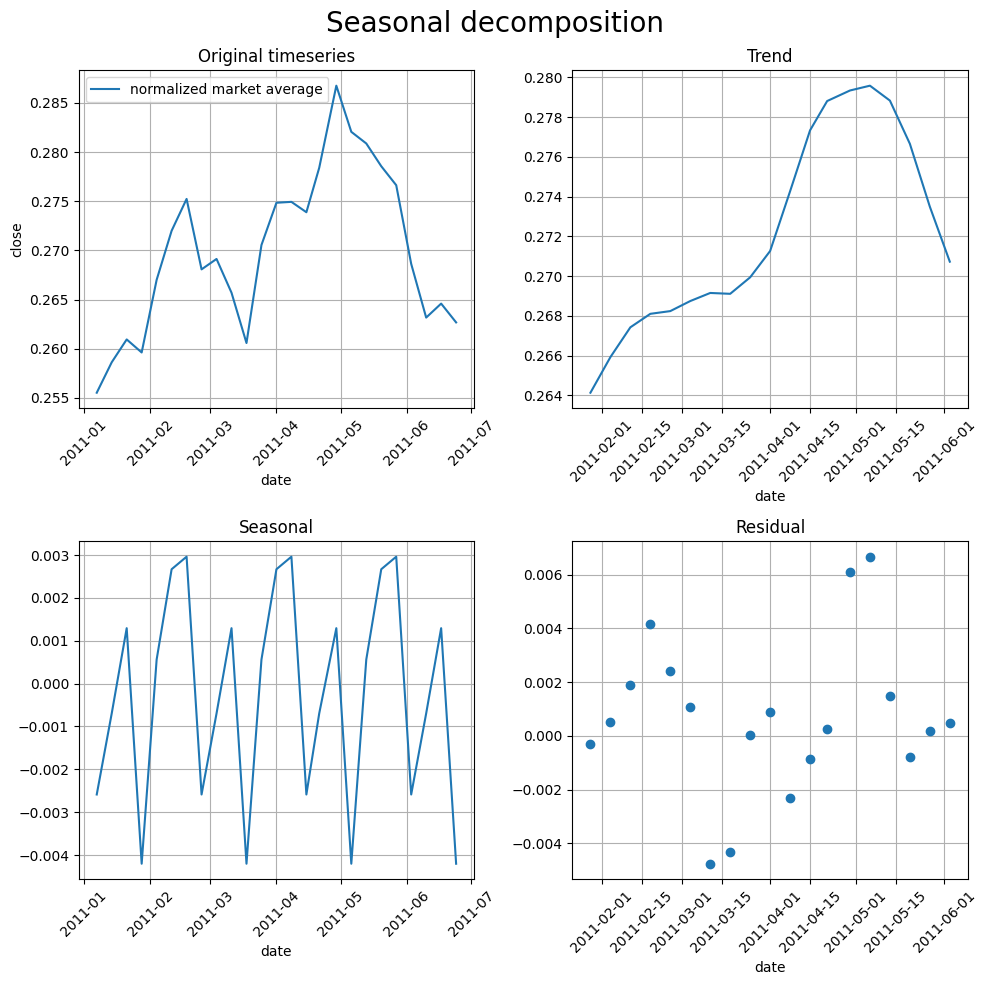

In [5]:
# Seasonal decomposition to reveal trend, seasonal component and residuals

# Applying seasonal decompotition with statsmodels.tsa
decomp = seasonal_decompose(close_df['close'], model='additive', period=7)     # I choose additive model here since the variance looks to be constant for this variable

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Seasonal decomposition', fontsize=20)

sns.lineplot(data=close_df, x=close_df.index, y='close', ax=ax[0, 0], label='normalized market average')
ax[0, 0].set_title('Original timeseries') 
ax[0, 0].grid()
ax[0, 0].tick_params(axis='x', labelrotation = 45)


decomp.trend.plot(ax=ax[0, 1])
ax[0, 1].set_title('Trend')
ax[0, 1].grid()
ax[0, 1].tick_params(axis='x', labelrotation = 45)

decomp.seasonal.plot(ax=ax[1, 0])
ax[1, 0].set_title('Seasonal')
ax[1, 0].grid()
ax[1, 0].tick_params(axis='x', labelrotation = 45)

decomp.resid.plot(marker='o', ax=ax[1, 1], linewidth=0)
ax[1, 1].set_title('Residual')
ax[1, 1].grid()
ax[1, 1].tick_params(axis='x', labelrotation = 45)

plt.tight_layout()
plt.show()

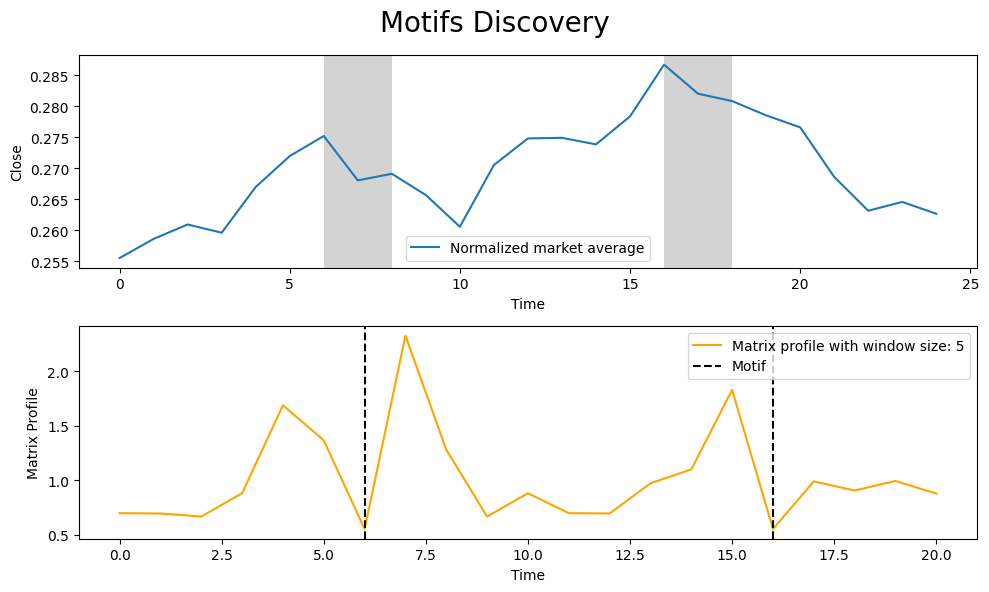

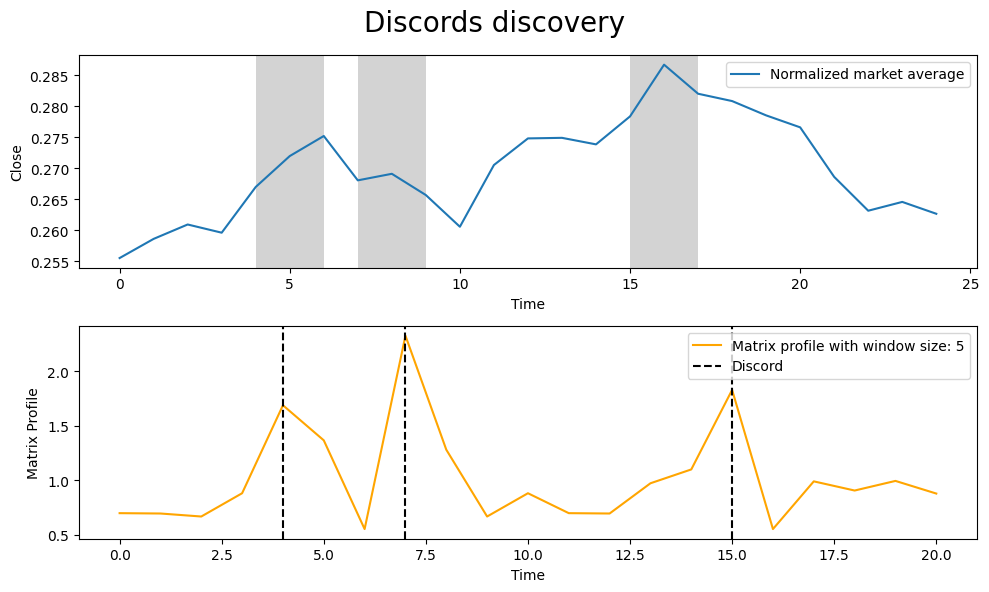

In [6]:
# Creating the matrix profile to find discords and motifs

# We use the stumpy library to create the profile. We set the rolling window size to 5 for this.
m=5
matrix_profile = stumpy.stump(close_df['close'], m=m)
profile = np.array(matrix_profile)[:, 0]

#Finding motifs by getting the index of the smallest values in the matrix profile
motif_idx = np.argsort(profile)[0]
nearest_neighbor_idx = matrix_profile[motif_idx, 1]

# Finding discords by getting the largest values
discord_idx1 = np.argsort(profile)[-1]
discord_idx2 = np.argsort(profile)[-2]
discord_idx3 = np.argsort(profile)[-3]

# Plotting the motif discovery, inspiration taken from the stumpy officiall documentation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plt.suptitle('Motifs Discovery', fontsize=20)

sns.lineplot(data=close_df, x=range(len(close_df.index)), y='close', ax=ax1, label='Normalized market average')
ax1.set_ylabel('Close')
ax1.set_xlabel('Time')
rect = Rectangle((motif_idx, 0), 2, 40, facecolor='lightgrey')
ax1.add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), 2, 40, facecolor='lightgrey')
ax1.add_patch(rect)

sns.lineplot(y=profile, x=range(len(profile)), label=f'Matrix profile with window size: {m}', ax=ax2, color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('Matrix Profile')
ax2.axvline(x=motif_idx, linestyle="dashed", color='black', label='Motif')
ax2.axvline(x=nearest_neighbor_idx, linestyle="dashed", color='black')

plt.legend()
plt.tight_layout()
plt.show()

# Plotting the discord discovery
# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plt.suptitle('Discords discovery', fontsize=20)

sns.lineplot(data=close_df, x=range(len(close_df.index)), y='close', ax=ax1, label='Normalized market average')
ax1.set_ylabel('Close')
ax1.set_xlabel('Time')
rect = Rectangle((discord_idx1, 0), 2, 40, facecolor='lightgrey')
ax1.add_patch(rect)
rect = Rectangle((discord_idx2, 0), 2, 40, facecolor='lightgrey')
ax1.add_patch(rect)
rect = Rectangle((discord_idx3, 0), 2, 40, facecolor='lightgrey')
ax1.add_patch(rect)

sns.lineplot(y=profile, x=range(len(profile)), label=f'Matrix profile with window size: {m}', ax=ax2, color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('Matrix Profile')
ax2.axvline(x=discord_idx1, linestyle="dashed", color='black', label='Discord')
ax2.axvline(x=discord_idx2, linestyle="dashed", color='black')
ax2.axvline(x=discord_idx3, linestyle="dashed", color='black')


plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# We can identify periods around the discrods and use these time periods to find external sources that may have affected the DJIA. For this, we used ChatGPT to help us find some sources and summarize them for us. 
# Unfortunately, there are very few working sites with information about the DJIA during this time period. 

# Anomaly period 1 explanation
anomaly_period1_start = close_df.index[discord_idx1]
anomaly_period1_end = close_df.index[discord_idx1 + m]
print(f'Anomaly period 1 starts {anomaly_period1_start} and ends {anomaly_period1_end}')

# Found these market reports to explain the market:
# https://www.arkansasonline.com/news/2011/jun/10/stocks-rise-1st-time-june-20110610/?utm_source=chatgpt.com
# https://www.marketwatch.com/story/us-stocks-decline-as-investors-mull-quakes-impact-djia-off-118-2011-03-14?utm_source=chatgpt.com

# Anomaly period 2 explanation
anomaly_period2_start = close_df.index[discord_idx2]
anomaly_period2_end = close_df.index[discord_idx2 + m]
print(f'Anomaly period 2 starts {anomaly_period2_start} and ends {anomaly_period2_end}')

# Found these market reports to explain the market:
# https://www.publishersweekly.com/pw/by-topic/industry-news/financial-reporting/article/47142-industry-stocks-april-2011-performances.html?utm_source=chatgpt.com

# Anomaly period 3 explanation
anomaly_period3_start = close_df.index[discord_idx3]
anomaly_period3_end = close_df.index[discord_idx3 + m]
print(f'Anomaly period 3 starts {anomaly_period3_start} and ends {anomaly_period3_end}')

# Found these market reports to explain the market:
# https://www.nasdaq.com/articles/5-worst-disasters-how-did-stock-market-react-2011-03-25?utm_source=chatgpt.com

Anomaly period 1 starts 2011-02-25 and ends 2011-04-01
Anomaly period 2 starts 2011-04-21 and ends 2011-05-27
Anomaly period 3 starts 2011-02-04 and ends 2011-03-11


<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">

**Exploratory questions**
- Can we find and use a clustering algorithm to perform unsupervised classification of the time series to find interesting classes? Can we relate the identified patterns to real-world factors? ✅

2


<Figure size 640x480 with 0 Axes>

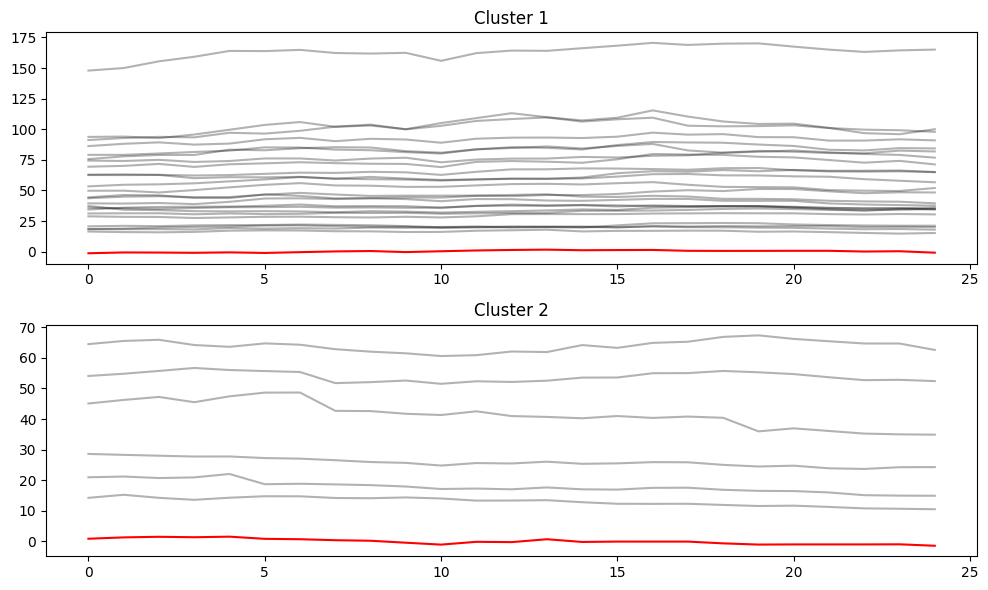

In [8]:
# Timeseries clustering with Dynamic timewarping to compare and find similar stocks

# Used ChatGPT for the preprocessing since we could not figure out the ducomentation on our own. 
all_stocks = dow_jones[['stock', 'close']]
all_stocks = pd.DataFrame(all_stocks)
all_stocks["group"] = all_stocks.groupby("stock").cumcount()
pivoted_df = all_stocks.pivot(index="group", columns="stock", values="close")
pivoted_df.reset_index(drop=True, inplace=True)
pivoted_df = pivoted_df.T
data = pivoted_df.to_numpy().reshape(pivoted_df.shape[0], pivoted_df.shape[1], 1)

X_train_clsuter = TimeSeriesResampler(sz=25).fit_transform(data)
X_train_cluster= TimeSeriesScalerMeanVariance().fit_transform(X_train_clsuter)

# Creating a function to find the lowest average silhuette score 
def find_optimal_k(data, clusters):
    sil_scores = {}
    for n_clusters in clusters:
        model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
        y_pred = model.fit_predict(data)
        distance_matrix = cdist_dtw(X_train_cluster)

        # Compute and store the silhuette scores
        sil_avg = silhouette_score(distance_matrix, y_pred,  metric="precomputed")
        sil_scores[n_clusters] = sil_avg
    optimal_k = max(sil_scores, key=sil_scores.get)
    return optimal_k, min(sil_scores.values())

# Calling the function to find the optimal k
n_clusters_to_try = range(2, 10, 1)
optimal_k, avg_sil_score = find_optimal_k(X_train_clsuter, n_clusters_to_try)
print(optimal_k)

# Creating the model and making a preduction
model = TimeSeriesKMeans(n_clusters=optimal_k, metric="dtw", random_state=42)
y_pred = model.fit_predict(X_train_cluster)

# Plotting taken from the TSLearn documentation
plt.clf()
plt.figure(figsize=(10, 6))
for yi in range(optimal_k):
    plt.subplot(optimal_k, 1, 1 + yi)
    for xx in X_train_clsuter[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.3)
    plt.plot(model.cluster_centers_[yi].ravel(), color="red")
    plt.title("Cluster %d" % (yi + 1))
plt.tight_layout()
plt.show()

    ### Här kanske vi borde försöka hitta vilka aktier som hamnar i vilket cluster?

<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">

**Exploratory questions**
- Can we combine insights from the time series components, the predicted classes and discords/motifs to generate new insights about the market? 


In [9]:
## Antar att vi måste göra detta i raporten sen kanske?

<div style="background-color:rgb(255, 132, 91); padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">

# 5-C: Answer the Predictive Question
</div>

<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">

1. **Split the data**:
- Split your data into training (80%) and testing (20%) sets, with an additional 20% of
the training data reserved for validation. 

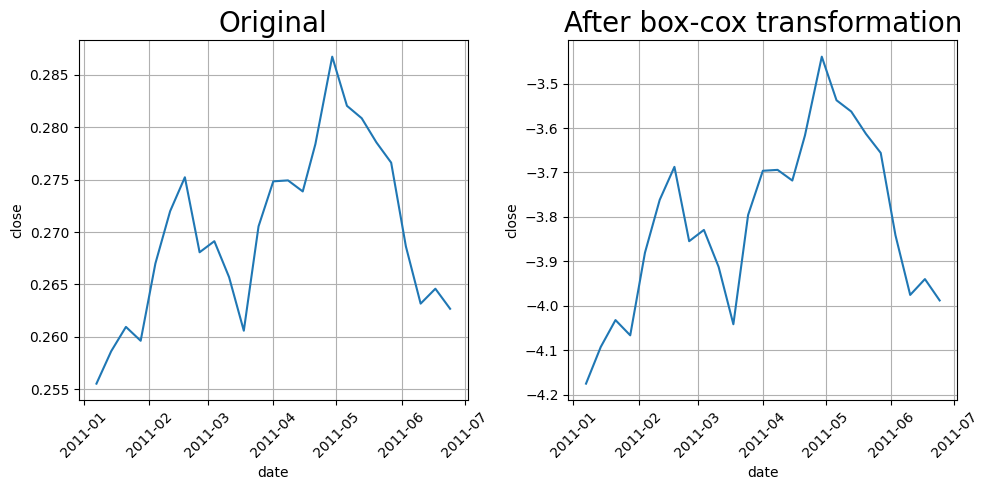

In [10]:
# Since stock markets are typically not stationary and contains trend ans seasonality components as seen in the decomposition, 
# we will use a SARIMA model to predict future values. We do however need to fix the non-constant vairance with a box-cox transformation.

# Box cox transformation 
close_df_boxcox = close_df.assign(close=boxcox(close_df['close'])[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=close_df, x=close_df.index, y='close', ax=ax1)
sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', ax=ax2)
ax1.grid()
ax2.grid()
ax1.tick_params(axis='x', labelrotation = 45)
ax2.tick_params(axis='x', labelrotation = 45)
ax1.set_title('Original', fontsize=20)
ax2.set_title('After box-cox transformation', fontsize=20)
plt.tight_layout()
plt.show()

# For our purposes, we are splitting the data into only training and testing sets since we can otherwise not make a forecast with the provided libraries without having data leakage. 

# 80/20 split
X_train = close_df_boxcox.iloc[:20]
X_test = close_df_boxcox.iloc[20:]

<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">

2. **Build and improve the model**:

- Build and improve your model through at least 5 iterations. Start with a simple
model (e.g., linear or logistic regression), and improve it by modifying datasets,
algorithms, or hyperparameters. Document each change. 


***Predictive question***:
- Can we create a SARIMA model to accurately predict the value of the Dow Jones index/market average in a given timeframe? If not, what other models can yield better results? 
- What method of hyperparameter tuning works best for our model? 

In [11]:
# Iteration 1 - Auto arima to find the best model with grid search.

# Creating a SARIMA model that automatically finds the model with the lowest AIC score though iterating over different 
# combinations of p,d,q,P,D,Q paramters. Since the m parameter of the seasonal component does not affect the AIC score

m_vals_to_try = [2, 4, 7, 12, 16]    
aic_scores = []

for m in m_vals_to_try:
    auto_model = auto_arima(X_train, 
                    
                    start_p=1,
                    start_q=1, 
                    d=1, 
                    max_p=10, 
                    max_q=10, 
                    
                    start_P=0,
                    start_Q=0,
                    D=1,
                    max_P=10,
                    max_Q=10,

                    m=m,
                    
                    information_criterion='aic',
                    trace=True, 
                    error_action='ignore',
                    suppress_warnings=True, 
                    stepwise=True)

    auto_model.fit(X_train)
    aic_scores.append({m:auto_model.aic()})
    forecast = auto_model.predict(n_periods=len(X_test))

# Based on this, we can see that the model with m=1 has the lowest AIC score, which means it has the best fit. 
print(f'\nAll AIC scores: {aic_scores}\n')
# Best model: Best model:  ARIMA(0,1,0)(1,1,0)[2]          

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[2]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[2]             : AIC=-8.111, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[2]             : AIC=-11.743, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[2]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[2]             : AIC=-6.121, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[2]             : AIC=-10.233, Time=0.07 sec
 ARIMA(1,1,0)(1,1,1)[2]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,1)[2]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(2,1,1)[2]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(1,1,0)[2]             : AIC=-13.657, Time=0.03 sec
 ARIMA(0,1,0)(2,1,0)[2]             : AIC=-12.195, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[2]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[2]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(2,1,1)[2]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(1,1,0)[2]             : AIC=-11.765, Time=0.04 sec
 ARIMA(1,1,1)(1,

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-9.208, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-11.436, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-8.546, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-7.877, Time=0.03 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=-9.667, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,1,1)[4]          
Total fit time: 1.410 seconds


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=-9.818, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-11.235, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-11.082, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=-11.121, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-11.104, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-9.121, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-10.668, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-11.638, Time=0.03 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-11.880, Time=0.08 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-9.880, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-9.880, Time=0.13 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-7.880, Time=0.13 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=-9.880, Time=0.16 sec
 ARIMA(0,1,2)(1,1,0)[7]             : AIC=inf, Time=0.10 

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-5.422, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-7.687, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3.712, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-5.077, Time=0.09 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-5.687, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-5.687, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-3.687, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-5.712, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-7.076, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=-6.258, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.393 seconds
Performing stepwise search to minimize aic


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,1,0)[16]             : AIC=-0.596, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[16]             : AIC=-2.420, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[16]             : AIC=0.168, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[16]             : AIC=0.311, Time=0.21 sec
 ARIMA(0,1,0)(1,1,0)[16]             : AIC=-0.420, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[16]             : AIC=-0.420, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[16]             : AIC=1.580, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[16]             : AIC=-1.832, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[16]             : AIC=-1.687, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[16] intercept   : AIC=-3.661, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[16] intercept   : AIC=-1.661, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[16] intercept   : AIC=-1.661, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[16] intercept   : AIC=0.339, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[16] intercept   : AIC=-1.662, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[16] intercept   : AIC=-1.661, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[16] inte

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

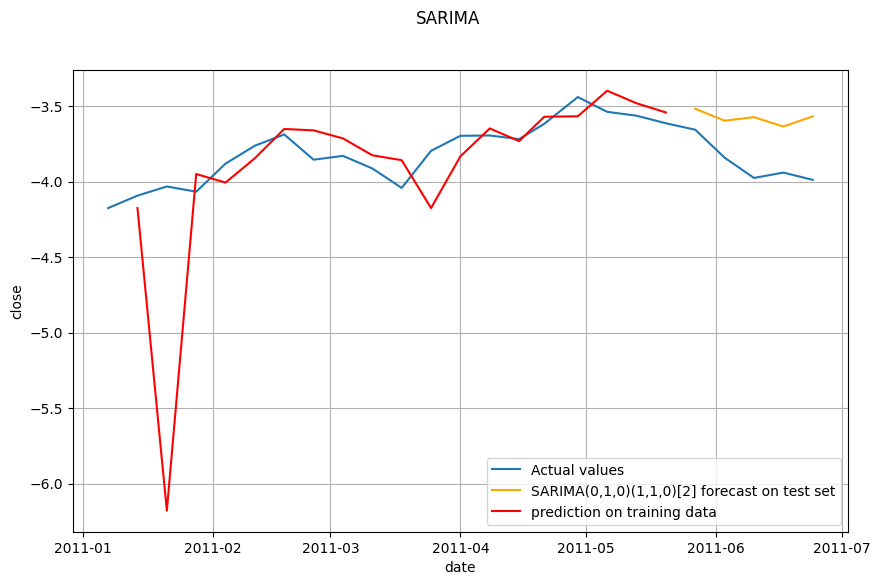

In [21]:
# Iteration 2, creating a new SARIMA model with the best parameters and making a prediction
sarima_model = ARIMA(X_train, order=(0,1,0), seasonal_order=(1,1,0,2)).fit()
prediction = sarima_model.predict(start=X_train.index[1], end=X_train.index[-1], n_periods = len(X_train.index))
forecast = sarima_model.forecast(len((X_test)))

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.suptitle(f'SARIMA')

sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', label='Actual values')
sns.lineplot(y=forecast, x=X_test.index, color='orange', label='SARIMA(0,1,0)(1,1,0)[2] forecast on test set')
sns.lineplot(x=X_train.index[1:], y=prediction.values, color='red', label='prediction on training data')
ax.grid()

plt.tight_layout
plt.legend()
plt.show()

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


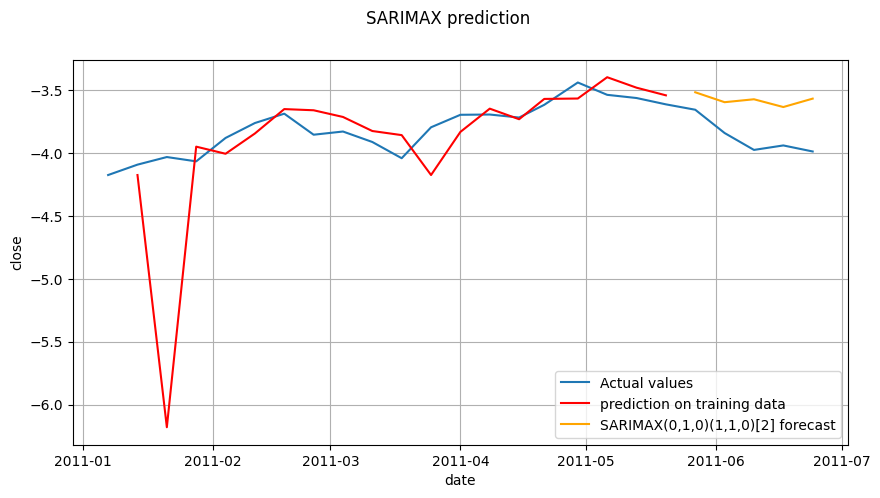

In [23]:
# Iteration 3 - SARIMAX model without exogenous variables

# Fit the SARIMAX model
sarimax_model = SARIMAX(X_train, order=(0,1,0), seasonal_order=(1,1,0,2)).fit(disp=False)

prediction = sarimax_model.predict(start=X_train.index[1], end=X_train.index[-1], n_periods = len(X_train.index))
forecast = sarimax_model.forecast(steps=len(X_test))

# PLotting 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.suptitle(f'SARIMAX prediction')
sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', label='Actual values')
sns.lineplot(x=X_train.index[1:], y=prediction.values, color='red', label='prediction on training data')
sns.lineplot(y=forecast, x=X_test.index, color='orange', label='SARIMAX(0,1,0)(1,1,0)[2] forecast')
ax.grid()
plt.tight_layout
plt.legend()
plt.show()

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


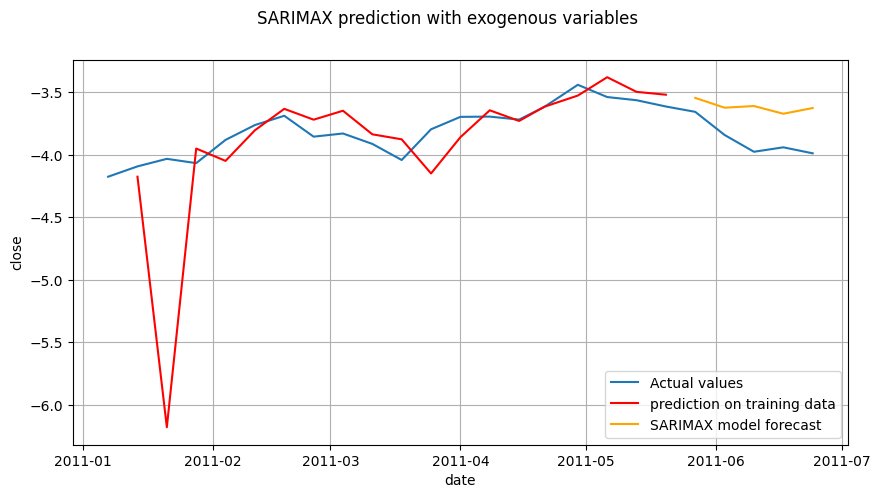

In [ ]:
# Iteration 4 - SARIMAX model with exogenous variables provided by the identified discords from the matrix profile

# Get the discords from earlier and make an ordered array with 1 where they appear, else 0.
top_three = sorted(list(profile), reverse=True)[:3]
discord_arr = np.array([1 if val in top_three and top_three.count(val) > 0 and top_three.remove(val) is None else 0 for val in profile])[:20].reshape(-1, 1)

# Fit the SARIMAX model
X_train = close_df_boxcox.iloc[:20]
X_test = close_df_boxcox.iloc[20:]
sarimax_model = SARIMAX(X_train, order=(0,1,0), seasonal_order=(1,1,0,2), exog=discord_arr).fit(disp=False)

prediction = sarimax_model.predict(start=X_train.index[1], end=X_train.index[-1], n_periods = len(X_train.index))
forecast = sarimax_model.forecast(steps=len(X_test), exog=np.zeros((5, 1)))     # Forecast requires exogenous variables to be provided as well. Here, we use a placeholder array with zeros since we can not predict the exogenous variables themselves. 

# Plotting 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.suptitle(f'SARIMAX prediction with exogenous variables')
sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', label='Actual values')
sns.lineplot(x=X_train.index[1:], y=prediction.values, color='red', label='prediction on training data')
sns.lineplot(y=forecast, x=X_test.index, color='orange', label='SARIMAX model forecast')
ax.grid()
plt.tight_layout
plt.legend()
plt.show()

# This did not improve or change the model in any meaningful way. The forecast is still not good. 

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra

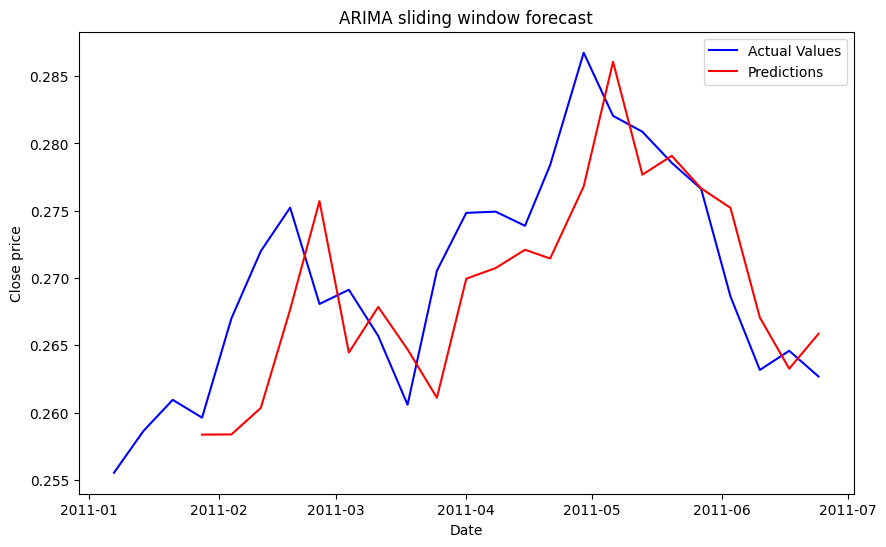

MSE of the rolling forecast: 0.0000


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra

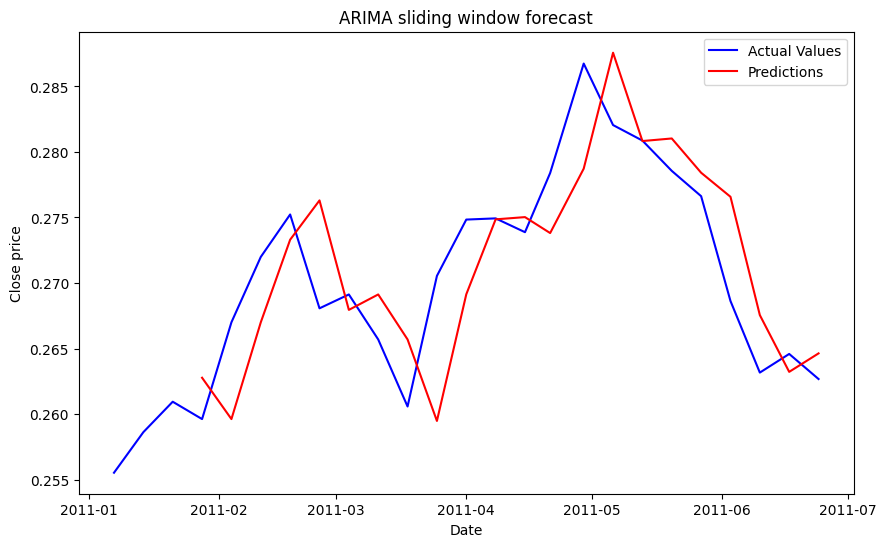

MSE of the rolling forecast: 0.0000


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra

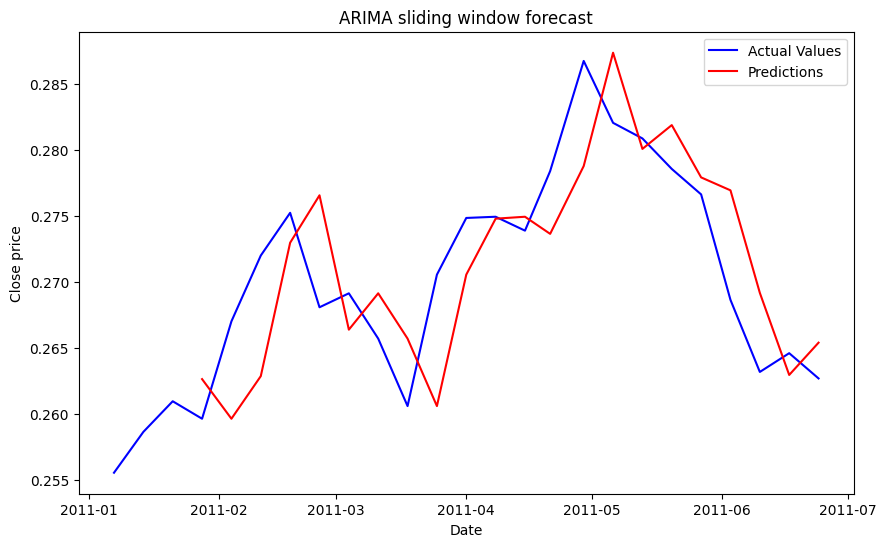

MSE of the rolling forecast: 0.0000


In [36]:
# Iteration 5 - Extending/rolling window approach. 

initial_training_window_size = 3
forecast_steps = 1

# function to run sliding window arima, plot the results and return predictions, actual values and params for the model. 
def run_arima (window_size, forecast_steps, data, p, d, q):
    
    predictions = []
    actual_values = []
    params = [p, d, q]
    for i in range(window_size, len(data)):
    
        train_data = data["close"].iloc[0:i]
        test_data = data["close"].iloc[i]

        arima_model = ARIMA(train_data, order=(p, d, q))  #pdq AR order, degree of differentiating, MA order.
        arima_results = arima_model.fit()
    
        forecast = arima_results.forecast(steps=forecast_steps)
        predictions.append(forecast)
        actual_values.append(test_data)

    rolling_predictions_series = pd.Series(predictions, index=close_df.index[window_size:])
    rolling_actual_series = pd.Series(actual_values, index=close_df.index[window_size:])

    plt.figure(figsize=(10, 6))
    plt.plot(data.index, close_df["close"], label="Actual Values", color="blue")
    plt.plot(rolling_predictions_series.index, rolling_predictions_series, label="Predictions", color="red")
    plt.legend()
    plt.title("ARIMA sliding window forecast")
    plt.xlabel("Date")
    plt.ylabel("Close price")
    plt.show()
    
    mse = mean_squared_error(actual_values, predictions)
    print(f"MSE of the rolling forecast: {mse:.4f}")
    
    return predictions, actual_values, mse, params



predictions, actual, mse, params =  run_arima(3, 1, close_df, 1, 0, 1)
predictions1, actual1, mse1, params1 =  run_arima(3, 1, close_df, 1, 1, 1)
predictions2, actual2, mse2, params2 =  run_arima(3, 1, close_df, 2, 1, 2)

<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">

***Predictive question***:
- What timeseries decomposition methods work best for improving the predictions and/or efficiency of our model? ❌

<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">

***Predictive question***:
- Can we in other ways engineer the features to improve the accuracy and or efficiency of our model? ❌

<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">

3. **Report model performance**:
- Regression: Mean Absolute Error (MAE). ❌
- Classification: Accuracy, and, for imbalanced classes, balanced accuracy or
ROC AUC. ❌